In [1]:
import warnings
from itertools import combinations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import numpy as np

from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_spikes_synaptic
from timescales.fit import convert_knee_val, fit_psd
from timescales.optimize import fit_grid

### Addressing Finite Duration Bias with Grid Search

This notebook examines if hyperparameter gridsearch can be used to minimize finite duration bias. Taking the mean timescale of a grid of parameters significantly reduces finite duration bias. Specifically bias from 1s simulation approaches a comparable timescale variance as from 10s simulations, when the mean of the grid is used. This means that gridsearch may be an alternative to Zeraati 2021, which uses a Bayesian model to reduce bias. Both methods are slow, but direct comparison may be useful to see which method performs better.

The grid could be further explored to determine which hyperparamaters are most useful for reducing bias. Eliminating parameters that aren't useful could speed up computation time or accuracy.

In [2]:
def get_knee(probs, fs):
    
    try:
        freqs, powers = compute_spectrum(probs, fs, f_range=(1, 100))
        _, knee_freq, _ = fit_psd(freqs, powers, (1, 100))
    except:
        get_knee(probs, fs)
        
    return knee_freq

def fit_grid_no_warnings(sig, fs, grid, max_n_params=int(1e3)):
    
    with warnings.catch_warnings():
        
        warnings.simplefilter("ignore")
        
        params = fit_grid(sig, fs, grid, mode='psd', max_n_params=max_n_params,
                          n_jobs=-1, chunksize=20)
        
        knees = np.array([p[1] for p in params])
        
    return knees

In [3]:
n_seconds_params = [1, 10, 100]
fs = 1000
n_iters = 100

knee_freqs = np.zeros((len(n_seconds_params), n_iters))

seed_ind = 0
for ind, n_seconds in enumerate(n_seconds_params):
    
    for n in tqdm(range(n_iters)):
        np.random.seed(seed_ind)
        seed_ind += 1
                  
        probs, _ = sim_spikes_synaptic(n_seconds, fs, convert_knee_val(10))
        
        _knee_freq = get_knee(probs, fs)
            
        knee_freqs[ind][n] = _knee_freq

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Baseline: No Grid Search

Text(0.5, 0, 'Seconds')

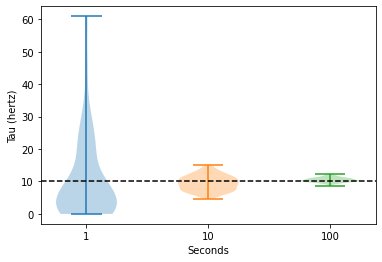

In [10]:
plt.violinplot(knee_freqs[0])

plt.violinplot(knee_freqs[1], positions=[2])

plt.violinplot(knee_freqs[2], positions=[3])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2, 3], labels=['1', '10', '100'])
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')

### Grid Search

In [5]:
specparam_grid = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': np.array([[.1, 20]]),
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]])
}

In [17]:
fs = 1000
n_iters = 100

knee_freqs_grid = np.zeros((n_iters, int(1e3)))

seed_ind = 0
for n in tqdm(range(n_iters), total=n_iters):

    np.random.seed(seed_ind)
    seed_ind += 1

    probs, _ = sim_spikes_synaptic(1, fs, convert_knee_val(10))

    knee_freqs_grid[n] = fit_grid_no_warnings(probs, fs, specparam_grid, max_n_params=int(1e3))

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Seconds')

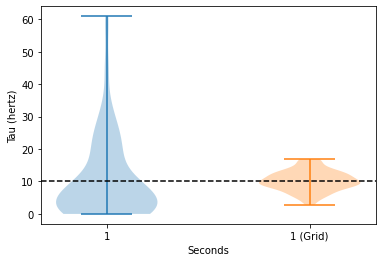

In [20]:
plt.violinplot(knee_freqs[0])

plt.violinplot(knee_freqs_grid.mean(axis=1), positions=[2])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2], labels=['1', '1 (Grid)'])
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')

Text(0.5, 0, 'Seconds')

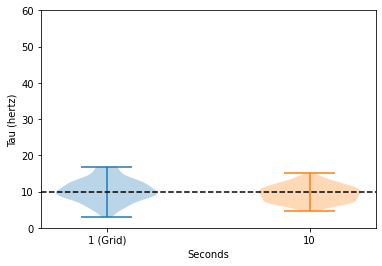

In [23]:
plt.violinplot(knee_freqs_grid.mean(axis=1))

plt.violinplot(knee_freqs[1], positions=[2])

plt.axhline(10, color='k', ls='--')

plt.xticks(ticks=[1, 2], labels=['1 (Grid)', '10'])
plt.ylim(0, 60)
plt.ylabel('Tau (hertz)')
plt.xlabel('Seconds')